<a href="https://colab.research.google.com/github/jiseungkyu/jsk/blob/master/cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

Files already downloaded and verified
Files already downloaded and verified
Epoch 1
-------------------------------
loss: 2.308237, acc: 0.062500 [    0/50000]
loss: 1.902619, acc: 0.296875 [12800/50000]
loss: 1.903540, acc: 0.335938 [25600/50000]
loss: 1.831588, acc: 0.312500 [38400/50000]
val 정확률= 36.273735761642456 

Epoch 2
-------------------------------
loss: 1.756806, acc: 0.304688 [    0/50000]
loss: 1.624654, acc: 0.382812 [12800/50000]
loss: 1.796525, acc: 0.398438 [25600/50000]
loss: 1.713764, acc: 0.375000 [38400/50000]
val 정확률= 40.79311788082123 

Epoch 3
-------------------------------
loss: 1.616604, acc: 0.398438 [    0/50000]
loss: 1.536940, acc: 0.429688 [12800/50000]
loss: 1.709018, acc: 0.429688 [25600/50000]
loss: 1.636303, acc: 0.421875 [38400/50000]
val 정확률= 43.91811788082123 

Epoch 4
-------------------------------
loss: 1.531832, acc: 0.460938 [    0/50000]
loss: 1.471828, acc: 0.445312 [12800/50000]
loss: 1.631639, acc: 0.429688 [25600/50000]
loss: 1.573248, 

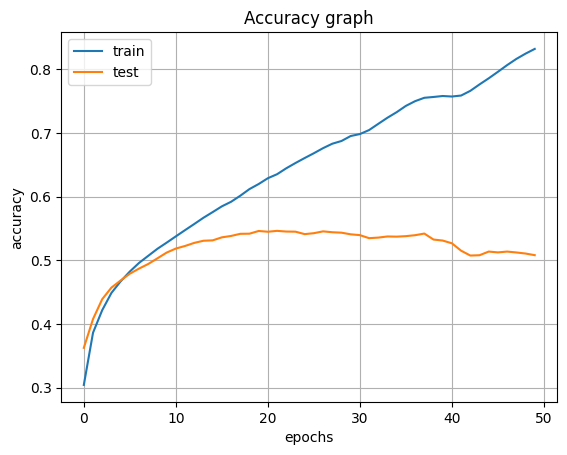

In [9]:
class SequentialModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.reshape = nn.Flatten() # 다차원 입력을 1차원으로 펼침
        self.model = nn.Sequential(
            nn.Linear(3072, 1024), # 3072개의 입력을 받아 1024개의 출력을 생성
            nn.ReLU(), #RELU 사용
            nn.Linear(1024, 512), # 1024개의 출력을 받아 512개의 출력을 생성
            nn.ReLU(),
            nn.Linear(512, 512), # 512개의 입력을 받아 512개의 출력 생성
            nn.ReLU(),
            nn.Linear(512, 10), # 512개의 입력을 받아 10개의 출력 생성
        )

    def forward(self, x):
        x = self.reshape(x) # 입력을 1차원으로 펼침
        x = self.model(x) # 펼쳐진 x를 순차적으로 정의된 레이어에 통과
        return x



# 모델 학습
def training_epoch(dataloader, device, model, loss_fn, optimizer, metric):
    size = len(dataloader.dataset) # 데이터셋의 크기를 저장
    num_batches = len(dataloader) # 배치의 총 개수 저장
    total_loss = 0 # 손실 초기화
    acc_list = [] # 리스트 초기화
    model.train() # 학습 모드로 설정
    for batch, (x, y) in enumerate(dataloader): # 데이터로더로부터 배치를 가져옴
        x = x.to(device) # x 전송
        y = y.to(device) # y 전송

        y_hat = model(x) # 모델에 입력을 전달
        loss = loss_fn(y_hat, y) # 예측과 실제 레이블 간의 손실 계산
        total_loss += loss.item() # 현재 배치의 손실을 누적
        acc = metric(y_hat, y) # 정확도 계산
        acc_list.append(acc) # 정확도를 리스트에 추가

        optimizer.zero_grad() # 이전 배치의 그래디언트 초기화
        loss.backward() # 현재 배치의 손실에 대한 그래디언트 계산
        optimizer.step() # 옵티마이저를 사용해 파라이터 업데이트

        # 매 배치마다 현재 손실과 정확도 출력
        if batch % 100 == 0:
            loss = loss.item()
            current = batch * len(x)
            print(f"loss: {loss:>7f}, acc: {acc:>7f} [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 현재 에포크에서의 평균 정확도 계산
    return total_loss, mean_acc # 정확도와 손실 리스트 반환

# 검증 데이터 손실 계산
def validation(dataloader, device, model, loss_fn, metric):
    num_batches = len(dataloader)
    total_loss = 0 # 현 에포크에서 사용되는 배치의 총 개수 저장실 초기화
    acc_list = [] # 정확도 초기화
    model.eval() # 평가 모드로 설정
    with torch.no_grad(): # 평가에서는 그래디언트 계산 필요 없음
        for x, y in dataloader:
            x = x.to(device) # x 전송
            y = y.to(device) # y 전송

            y_hat = model(x) # 입력 후 예측
            loss = loss_fn(y_hat, y) # 손실 계산
            total_loss += loss.item() # 손실 누적
            acc = metric(y_hat, y) # 정확도 계산
            acc_list.append(acc) # 정확도 추가

    total_loss /= num_batches # 평균 손실 계산
    mean_acc = torch.tensor(acc_list).to(device).mean().item() # 평균 정확도 계산
    return total_loss, mean_acc # 평균 손실,정확도 반환


def test(dataloader, device, model, loss_fn, metric):
    _, mean_acc = validation(dataloader, device, model, loss_fn, metric) # 정확도 계산
    return mean_acc # 반환


# 데이터 준비
train_data = CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
train_loader = DataLoader(train_data, batch_size=128)
test_loader = DataLoader(test_data, batch_size=128)


# 모델 학습
device = "cuda" if torch.cuda.is_available() else "cpu" # gpu사용
dmlp = SequentialModel().to(device)  # SequentialModel 클래스로부터 모델을 생성하고, 이를 앞서 정의한 device로 이동
loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss 사용
optimizer = optim.Adam(dmlp.parameters(), lr=0.0001)  # Adam 옵티마이저 정의, 학습률 0.0001
metric = Accuracy(task="multiclass", num_classes=10).to(device)

max_epochs = 50
history = defaultdict(list)
for t in range(max_epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # 훈련 데이터에 대한 에포크 진행
    train_loss, train_acc = training_epoch(train_loader, device, dmlp, loss_fn, optimizer, metric)
    # 검증 데이터에 대한 에포크 진행
    val_loss, val_acc = validation(test_loader, device, dmlp, loss_fn, metric)
    print("val 정확률=", val_acc * 100, "\n")

    # 훈련 및 검증 손실, 정확도 기록
    history["loss"].append(train_loss)
    history["accuracy"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_acc)


# 훈련된 모델의 상태 저
torch.save(dmlp.state_dict(), "dmlp_trained.pth")

# 새로운 모델 생성 후 저장된 상태 적용
dmlp = SequentialModel().to(device)
dmlp.load_state_dict(torch.load("dmlp_trained.pth"))

print("정확률=", test(test_loader, device, dmlp, loss_fn, metric) * 100)

plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Accuracy graph")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["train", "test"])
plt.grid()
plt.show()

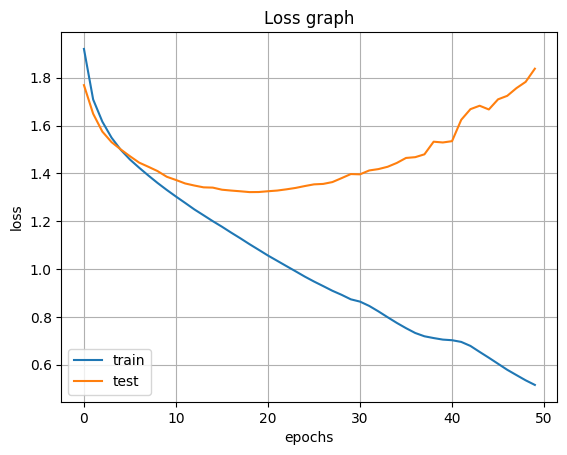

In [10]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["train", "test"])
plt.grid()
plt.show()